In [1]:
%load_ext autoreload
%autoreload 2

# Broadband SED / spectral analysis

## Required packages

In [2]:
import os,sys,glob

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib

from gammapy.datasets import Dataset, Datasets
from gammapy.modeling.models import (
    SkyModel,
    Models,
    TemplateSpectralModel,
    SpectralModel,
    EBLAbsorptionNormSpectralModel,
    GaussianPrior,
    UniformPrior,
    SmoothBrokenPowerLawSpectralModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
)

### Custom code
helpers = os.path.abspath('../../../Helpers')
if helpers not in sys.path:
    sys.path.append(helpers)
from hydrogen import (
    get_tbabs_template_model,
)
from dustextinction import (
    get_xredden_template_model,
)
from utils import (
    get_dataset_energy_edges,
    draw_sed_contours,
    contains_one_of
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.modeling import Fit, Parameter

from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.interpolate import RectBivariateSpline

In [3]:
basedir = os.path.abspath("../../../")
dataset = 'MJD60384'

## Datasets

In [4]:
# Read datasets
fermi_datasets = Datasets.read(f"{basedir}/LAT/{dataset}/dataset.yaml")
nustar_datasets = Datasets.read(f"{basedir}/NuSTAR/{dataset}/dataset.yaml")
xrt_datasets = Datasets.read(f"{basedir}/XRT/{dataset}/dataset.yaml")
uvot_datasets = Datasets.read(f"{basedir}/UVOT/{dataset}/dataset.yaml")
liverpool_datasets = Datasets.read(f"{basedir}/Liverpool_IOO/{dataset}/dataset.yaml")

# Stack Liverpool datasets by filter?
unique_bands = np.unique([d.name.split('_h_e_')[0] for d in liverpool_datasets])
liverpool_datasets = Datasets([Datasets([d for d in liverpool_datasets if band in d.name]).stack_reduce(name=band) for band in unique_bands])

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


## Models

In [5]:
# Read models
fermi_datasets.models     = list(Models.read(f"{basedir}/LAT/{dataset}/models.yaml"))
nustar_datasets.models    = list(Models.read(f"{basedir}/NuSTAR/{dataset}/models.yaml"))
xrt_datasets.models       = list(Models.read(f"{basedir}/XRT/{dataset}/models.yaml"))
uvot_datasets.models      = list(Models.read(f"{basedir}/UVOT/{dataset}/models.yaml"))
liverpool_datasets.models = list(Models.read(f"{basedir}/Liverpool_IOO/{dataset}/models.yaml"))

# Since we only have one filter in UVOT, instead of getting leaving a free LP model, use Liverpool's constraint.
uvot_datasets.models[0].parameters['alpha'].value = 1.900
uvot_datasets.models[0].parameters['beta'].value  = 0.313
uvot_datasets.models[0].parameters['alpha'].frozen = True
uvot_datasets.models[0].parameters['beta'].frozen  = True

Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1
HDU 'PSF' not found
HDU 'PSF' not found


## Absorption components

In [6]:
ebl_absorpt = EBLAbsorptionNormSpectralModel.read(f"{basedir}/Models/ebl_saldana-lopez_2021.fits.gz",redshift=0.997,alpha_norm=1)
hyd_absorpt = get_tbabs_template_model(f"{basedir}/Models/tbabs_tau_factor_vs_nH_energy.ecsv",srcname="OP313",freeze=True)
dust_extinc = get_xredden_template_model(f"{basedir}/Models/xredden_tau_factor_vs_EBV_energy.ecsv",srcname='OP313',freeze=True)
total_abs   = (ebl_absorpt*hyd_absorpt*dust_extinc)

In [7]:
# Apply absorption components
fermi_datasets[0].models['OP313'].spectral_model     = ExpCutoffPowerLawSpectralModel(reference=1*u.GeV,amplitude="1e-10 / (MeV s cm2)")
fermi_datasets.models['OP313'].spectral_model       *= ebl_absorpt
nustar_datasets.models['OP313'].spectral_model      *= hyd_absorpt
xrt_datasets.models['OP313'].spectral_model         *= hyd_absorpt
uvot_datasets.models['OP313'].spectral_model        *= dust_extinc
liverpool_datasets.models['OP313'].spectral_model   *= dust_extinc

### Fit each instrument

In [8]:
# Fermi-LAT
fermi_only_fit    = Fit(store_trace=True)
fermi_only_fit.optimize_opts = {"tol": 0.1, "strategy": 1, 'migrad_opts':{'ncall':10000, 'iterate': 10}}
fermi_only_result = fermi_only_fit.run(fermi_datasets)
print(fermi_only_result.message)
fermi_only_model  = fermi_datasets.models.copy()
energy_edges      = np.geomspace(100*u.MeV, 1000*u.GeV, 9)
energy_edges      = energy_edges[energy_edges<500*u.GeV]
fermi_only_fpe    = FluxPointsEstimator(energy_edges=energy_edges, source="OP313", selection_optional="all")
fermi_only_points = fermi_only_fpe.run(fermi_datasets).copy()

Optimization terminated successfully.


In [9]:
# NuSTAR
nustar_datasets.models['NuSTAR_A-bkg'].parameters['norm'].value = 1
nustar_datasets.models['NuSTAR_B-bkg'].parameters['norm'].value = 1
nustar_only_fit    = Fit(store_trace=True)
nustar_only_fit.optimize_opts = {"tol": 0.1, "strategy": 1, 'migrad_opts':{'ncall':10000, 'iterate': 10}}
nustar_only_result = nustar_only_fit.run(nustar_datasets)
print(nustar_only_result.message)
nustar_only_model  = nustar_datasets.models.copy()
energy_edges       = np.geomspace(2*u.keV, 80*u.keV, 9)
nustar_only_fpe    = FluxPointsEstimator(energy_edges=energy_edges, source="OP313", selection_optional="all")
nustar_only_points = nustar_only_fpe.run(nustar_datasets).copy()

HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found


Optimization terminated successfully.


In [10]:
# Swift-XRT
xrt_only_fit    = Fit(store_trace=True)
xrt_only_fit.optimize_opts = {"tol": 0.1, "strategy": 1, 'migrad_opts':{'ncall':10000, 'iterate': 10}}
xrt_only_result = xrt_only_fit.run(xrt_datasets)
print(xrt_only_result.message)
xrt_only_model  = xrt_datasets.models.copy()
energy_edges    = np.geomspace(0.3*u.keV, 10*u.keV, 8)
xrt_only_fpe    = FluxPointsEstimator(energy_edges=energy_edges, source="OP313", selection_optional="all")
xrt_only_points = xrt_only_fpe.run(xrt_datasets).copy()

Optimization terminated successfully.


In [11]:
# Swift-UVOT
uvot_only_fit     = Fit(store_trace=True)
uvot_only_fit.optimize_opts = {"tol": 0.1, "strategy": 1, 'migrad_opts':{'ncall':10000, 'iterate': 10}}
uvot_only_result  = uvot_only_fit.run(uvot_datasets)
print(uvot_only_result.message)
uvot_only_model   = uvot_datasets.models.copy()
energy_edge_pairs = [get_dataset_energy_edges(d) for d in uvot_datasets]
uvot_only_fpe     = [FluxPointsEstimator(energy_edges=edges, source="OP313") for edges in energy_edge_pairs]
uvot_only_points  = [uvot_only_fpe[k].run(datasets=d) for k,d in enumerate(uvot_datasets)]

Optimization terminated successfully.


In [12]:
# Liverpool
liverpool_only_fit     = Fit(store_trace=True)
liverpool_only_fit.optimize_opts = {"tol": 0.1, "strategy": 1, 'migrad_opts':{'ncall':10000, 'iterate': 10}}
liverpool_only_result  = liverpool_only_fit.run(liverpool_datasets)
print(liverpool_only_result.message)
liverpool_only_model   = liverpool_datasets.models.copy()
energy_edge_pairs      = [get_dataset_energy_edges(d) for d in liverpool_datasets]
liverpool_only_fpe     = [FluxPointsEstimator(energy_edges=edges, source="OP313") for edges in energy_edge_pairs]
liverpool_only_points  = [liverpool_only_fpe[k].run(datasets=d) for k,d in enumerate(liverpool_datasets)]

Optimization terminated successfully.


### Plot SEDs

In [13]:
def plot_model_points(ax,datasets,spectral_model,points,color,label,marker='o'):
    energy_edge_pairs     = [get_dataset_energy_edges(d,factor=0.1) for d in datasets]
    emin = min([min(pair) for pair in energy_edge_pairs]).to('eV')
    emax = max([max(pair) for pair in energy_edge_pairs]).to('eV')
    model=spectral_model
    draw_sed_contours(
        ax=ax,model=model,
        energy_edges=[emin,emax],
        color=color,facealpha=0.2,
        label=label)

    points = np.asarray([points,]).flatten()

    if ax is not None:
        old_lims = [min(ax.get_xlim()[0]*u.eV,emin),max(ax.get_xlim()[1]*u.eV,emax)]
    else:
        old_lims = [emin,emax]
    
    for point in points:
        ax = point.plot(
            ax=ax, color=color, mfc='white', sed_type='e2dnde', marker=marker
        )

    ax.set_xlim(old_lims)

    return(ax)

/home/mnievas/Projects/gammapy_mwl_workflow/Helpers/utils.py:84: RuntimeWarning: divide by zero encountered in log10
  yneg = 10**(2*np.log10(cen)-np.log10(cen+err))
/home/mnievas/Projects/gammapy_mwl_workflow/Helpers/utils.py:84: RuntimeWarning: invalid value encountered in subtract
  yneg = 10**(2*np.log10(cen)-np.log10(cen+err))


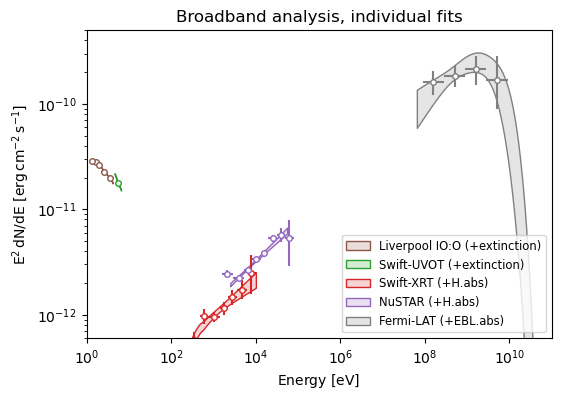

In [14]:
plt.figure(figsize=(6, 4),dpi=100)
ax = None
ax = plot_model_points(ax,liverpool_datasets,liverpool_only_model['OP313'].spectral_model,liverpool_only_points,'tab:brown','Liverpool IO:O (+extinction)')
ax = plot_model_points(ax,uvot_datasets,uvot_only_model['OP313'].spectral_model,uvot_only_points,'tab:green','Swift-UVOT (+extinction)')
ax = plot_model_points(ax,xrt_datasets,xrt_only_model['OP313'].spectral_model,xrt_only_points,'tab:red','Swift-XRT (+H.abs)')
ax = plot_model_points(ax,nustar_datasets,nustar_only_model['OP313'].spectral_model,nustar_only_points,'tab:purple','NuSTAR (+H.abs)')
ax = plot_model_points(ax,fermi_datasets,fermi_only_model['OP313'].spectral_model,fermi_only_points,'0.5','Fermi-LAT (+EBL.abs)')

ax.set_title('Broadband analysis, individual fits')
ax.set_ylim(6e-13,0.5e-9)
ax.set_xlim(1,1e11)
ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')
ax.legend(fontsize='small',loc=4,ncol=1)

## Priors for the broadband SED fit

In [15]:
# Set priors in the NuSTAR and Fermi background component normalizations to reduce degeneracy
for d in nustar_datasets:
    for c in d.models:
        if '-bkg' in c.name:
            d.models[c].spectral_model.norm.prior = GaussianPrior(
                mu    = d.models[c].spectral_model.norm.value,
                sigma = d.models[c].spectral_model.norm.error,
            )
for d in fermi_datasets:
    for c in ['fermi-diffuse-iso']:
        d.models[c].spectral_model.model2.norm.prior = GaussianPrior(
            mu    = d.models[c].spectral_model.model2.norm.value,
            sigma = d.models[c].spectral_model.model2.norm.error,
        )
    for c in ['diffuse-iem']:
        d.models[c].spectral_model.norm.prior = GaussianPrior(
            mu    = d.models[c].spectral_model.norm.value,
            sigma = d.models[c].spectral_model.norm.error,
        )

# Broadband SED [Model]

In [16]:
# Set a reasonable starting point by eye

def generate_model_intrinsic():
    expcutoffpwl1 = ExpCutoffPowerLawSpectralModel(
        amplitude="1.22 eV-1 cm-2 s-1",
        index=2,
        lambda_=0.1 * u.Unit("eV-1"),
        reference=4 * u.eV,
    )
    expcutoffpwl2 = ExpCutoffPowerLawSpectralModel(
        amplitude="20e-3 MeV-1 cm-2 s-1",
        index=1.6,
        lambda_=0.4 * u.Unit("GeV-1"),
        reference=10 * u.keV,
    )
    return(expcutoffpwl1+expcutoffpwl2)

## Broadband SED fit [Flux Points]

In [17]:
# Read datasets
fermi_datasets = Datasets.read(f"{basedir}/LAT/{dataset}/dataset.yaml")
nustar_datasets = Datasets.read(f"{basedir}/NuSTAR/{dataset}/dataset.yaml")
xrt_datasets = Datasets.read(f"{basedir}/XRT/{dataset}/dataset.yaml")
uvot_datasets = Datasets.read(f"{basedir}/UVOT/{dataset}/dataset.yaml")
liverpool_datasets = Datasets.read(f"{basedir}/Liverpool_IOO/{dataset}/dataset.yaml")

# Stack Liverpool datasets by filter?
unique_bands = np.unique([d.name.split('_h_e_')[0] for d in liverpool_datasets])
liverpool_datasets = Datasets([Datasets([d for d in liverpool_datasets if band in d.name]).stack_reduce(name=band) for band in unique_bands])

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


In [18]:
# Read models
fermi_datasets.models     = list(Models.read(f"{basedir}/LAT/{dataset}/models.yaml"))
nustar_datasets.models    = list(Models.read(f"{basedir}/NuSTAR/{dataset}/models.yaml"))
xrt_datasets.models       = list(Models.read(f"{basedir}/XRT/{dataset}/models.yaml"))
uvot_datasets.models      = list(Models.read(f"{basedir}/UVOT/{dataset}/models.yaml"))
liverpool_datasets.models = list(Models.read(f"{basedir}/Liverpool_IOO/{dataset}/models.yaml"))

# Set priors in the NuSTAR and Fermi background component normalizations to reduce degeneracy
for d in nustar_datasets:
    for c in d.models:
        if '-bkg' in c.name:
            d.models[c].spectral_model.norm.prior = GaussianPrior(
                mu    = d.models[c].spectral_model.norm.value,
                sigma = d.models[c].spectral_model.norm.error,
            )
for d in fermi_datasets:
    for c in ['fermi-diffuse-iso']:
        d.models[c].spectral_model.model2.norm.prior = GaussianPrior(
            mu    = d.models[c].spectral_model.model2.norm.value,
            sigma = d.models[c].spectral_model.model2.norm.error,
        )
    for c in ['diffuse-iem']:
        d.models[c].spectral_model.norm.prior = GaussianPrior(
            mu    = d.models[c].spectral_model.norm.value,
            sigma = d.models[c].spectral_model.norm.error,
        )

Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1
HDU 'PSF' not found
HDU 'PSF' not found


In [19]:
from gammapy.datasets import Datasets, FluxPointsDataset

list_flux_points = []
for k,fp in enumerate(fermi_only_points.to_table()):
    list_flux_points += [FluxPointsDataset(data=fermi_only_points.from_table(fp).copy(),name=f'Fermi-LAT.{k}')]
for k,fp in enumerate(nustar_only_points.to_table()):
    list_flux_points += [FluxPointsDataset(data=nustar_only_points.from_table(fp).copy(),name=f'NuSTAR.{k}')]
for k,fp in enumerate(xrt_only_points.to_table()):
    list_flux_points += [FluxPointsDataset(data=xrt_only_points.from_table(fp).copy(),name=f'Swift-XRT.{k}')]
for k,fp in enumerate(uvot_only_points):
    list_flux_points += [FluxPointsDataset(data=fp.copy(),name=f'Swift-UVOT.{k}')]
for k,fp in enumerate(liverpool_only_points):
    list_flux_points += [FluxPointsDataset(data=fp.copy(),name=f'Liverpool.{k}')]

In [20]:
systematics_lat = PowerLawNormSpectralModel()
systematics_lat.norm.prior = GaussianPrior(mu=1,sigma=0.05) # 3% in flux https://arxiv.org/pdf/1902.10045
systematics_nustar = PowerLawNormSpectralModel()
systematics_nustar.norm.prior = GaussianPrior(mu=1,sigma=0.03) # 3% in flux, https://nustarsoc.caltech.edu/NuSTAR_Public/NuSTAROperationSite/CALDB20211020.php
systematics_nustar.tilt.prior = GaussianPrior(mu=1,sigma=0.01) # 0.01 in spectral index, https://nustarsoc.caltech.edu/NuSTAR_Public/NuSTAROperationSite/CALDB20211020.php
systematics_xrt  = PowerLawNormSpectralModel()
systematics_xrt.norm.prior = GaussianPrior(mu=1,sigma=0.1) # 10% in absolute flux https://heasarc.gsfc.nasa.gov/docs/heasarc/caldb/swift/docs/xrt/SWIFT-XRT-CALDB-09.pdf
systematics_uvot   = PowerLawNormSpectralModel()
systematics_uvot.norm.prior = GaussianPrior(mu=1,sigma=0.1) # 10% in flux
systematics_liverpool = liverpool_only_model[0].spectral_model.model1.model1.copy()

def add_systematics(skymodel, syst, name=None, add_syst_bool=True):
    if add_syst_bool:
        skymodel_with_syst = SkyModel(
            name           = name if name is not None else skymodel.name,
            spatial_model  = skymodel.spatial_model,
            spectral_model = skymodel.spectral_model * syst,
        )
        return(skymodel_with_syst)
    else:
        return(skymodel)
    

In [21]:
spectral_model = generate_model_intrinsic()
sky_model_full = SkyModel(name='OP313',spectral_model=spectral_model*total_abs)
sky_model_LE   = SkyModel(name='OP313_LE',spectral_model=spectral_model.model1*total_abs)
sky_model_HE   = SkyModel(name='OP313_HE',spectral_model=spectral_model.model2*total_abs)

op313_model_LAT    = add_systematics(sky_model_HE,systematics_lat,'OP313-syst-LAT', False)
op313_model_NuSTAR = add_systematics(sky_model_HE,systematics_nustar,'OP313-syst-NuSTAR', False)
op313_model_XRT    = add_systematics(sky_model_HE,systematics_xrt,'OP313-syst-XRT', False)
op313_model_UVOT   = add_systematics(sky_model_LE,systematics_uvot,'OP313-syst-UVOT', False)
op313_model_LT     = add_systematics(sky_model_LE,systematics_liverpool,'OP313-syst-LT', False)

op313_model_LAT    = add_systematics(sky_model_full,systematics_lat,'OP313-syst-LAT', False)
op313_model_NuSTAR = add_systematics(sky_model_full,systematics_nustar,'OP313-syst-NuSTAR', False)
op313_model_XRT    = add_systematics(sky_model_full,systematics_xrt,'OP313-syst-XRT', False)
op313_model_UVOT   = add_systematics(sky_model_full,systematics_uvot,'OP313-syst-UVOT', False)
op313_model_LT     = add_systematics(sky_model_full,systematics_liverpool,'OP313-syst-LT', False)

In [22]:
joint_fluxpoint_datasets = Datasets(list_flux_points)
for fp in joint_fluxpoint_datasets:
    if 'Fermi-LAT' in fp.name:
        fp.models = [op313_model_LAT]
    elif 'NuSTAR' in fp.name:
        fp.models = [op313_model_NuSTAR]
    elif 'Swift-XRT' in fp.name:
        fp.models = [op313_model_XRT]
    elif 'Swift-UVOT' in fp.name:
        fp.models = [op313_model_UVOT]
    elif 'Liverpool' in fp.name:
        fp.models = [op313_model_LT]

joint_fluxpoint_datasets_HE = Datasets([da for da in list_flux_points \
                                    if contains_one_of(da.name,['Fermi','NuSTAR','Swift-XRT'])])
joint_fluxpoint_datasets_LE = Datasets([da for da in list_flux_points \
                                    if contains_one_of(da.name,['Swift-UVOT','Liverpool'])])

/home/mnievas/Projects/gammapy_mwl_workflow/Helpers/utils.py:84: RuntimeWarning: divide by zero encountered in log10
  yneg = 10**(2*np.log10(cen)-np.log10(cen+err))
/home/mnievas/Projects/gammapy_mwl_workflow/Helpers/utils.py:84: RuntimeWarning: invalid value encountered in subtract
  yneg = 10**(2*np.log10(cen)-np.log10(cen+err))


Text(0, 0.5, '$\\mathrm{E^2\\,dN/dE}$ $\\mathrm{[erg\\,cm^{-2}\\,s^{-1}]}$')

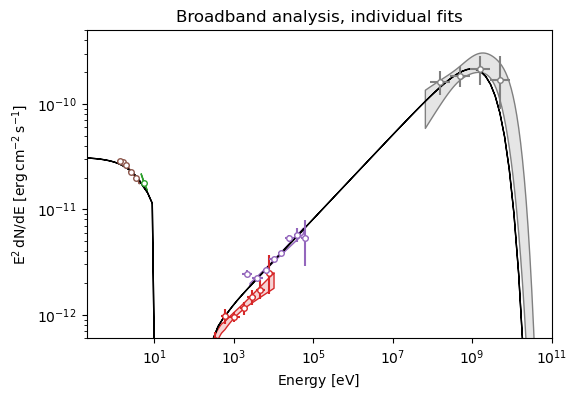

In [23]:
plt.figure(figsize=(6, 4),dpi=100)
ax = None
ax = plot_model_points(ax,liverpool_datasets,liverpool_only_model['OP313'].spectral_model,liverpool_only_points,'tab:brown','Liverpool IO:O (+extinction)')
ax = plot_model_points(ax,uvot_datasets,uvot_only_model['OP313'].spectral_model,uvot_only_points,'tab:green','Swift-UVOT (+extinction)')
ax = plot_model_points(ax,xrt_datasets,xrt_only_model['OP313'].spectral_model,xrt_only_points,'tab:red','Swift-XRT (+H.abs)')
ax = plot_model_points(ax,nustar_datasets,nustar_only_model['OP313'].spectral_model,nustar_only_points,'tab:purple','NuSTAR (+H.abs)')
ax = plot_model_points(ax,fermi_datasets,fermi_only_model['OP313'].spectral_model,fermi_only_points,'0.5','Fermi-LAT (+EBL.abs)')
draw_sed_contours(ax=ax,model=spectral_model*total_abs,
                  energy_edges=[0.2*u.eV,1e11 *u.eV],color='black',facealpha=0.2,label='Initial model for fit')

ax.set_title('Broadband analysis, individual fits')
ax.set_ylim(6e-13,0.5e-9)
ax.set_xlim(0.2,1e11)
ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')


In [24]:
joint_fluxpoint_datasets_HE = Datasets([fp for fp in joint_fluxpoint_datasets \
                               if contains_one_of(fp.name,['Fermi','NuSTAR','Swift-XRT'])])
joint_fluxpoint_datasets_LE = Datasets([fp for fp in joint_fluxpoint_datasets \
                               if contains_one_of(fp.name,['Swift-UVOT','Liverpool'])])

In [25]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)

migrad_opts={"ncall": 10000, "iterate": 5}
joint_fluxpoint_fit                    = Fit(store_trace=True)
print('Fitting HE+LE')
joint_fluxpoint_fit.optimize_opts      = {"tol": 0.1, "strategy": 2, 'migrad_opts':migrad_opts}
joint_fluxpoint_fit_result_abs         = joint_fluxpoint_fit.run(joint_fluxpoint_datasets)
print(joint_fluxpoint_fit_result_abs.message)

Fitting HE+LE
Optimization terminated successfully.


In [26]:
joint_fluxpoint_fit_result_abs.models

## Broadband SED fit [Forward folding]

In [27]:
# Read datasets
fermi_datasets = Datasets.read(f"{basedir}/LAT/{dataset}/dataset.yaml")
nustar_datasets = Datasets.read(f"{basedir}/NuSTAR/{dataset}/dataset.yaml")
xrt_datasets = Datasets.read(f"{basedir}/XRT/{dataset}/dataset.yaml")
uvot_datasets = Datasets.read(f"{basedir}/UVOT/{dataset}/dataset.yaml")
liverpool_datasets = Datasets.read(f"{basedir}/Liverpool_IOO/{dataset}/dataset.yaml")

# Stack Liverpool datasets by filter?
unique_bands = np.unique([d.name.split('_h_e_')[0] for d in liverpool_datasets])
liverpool_datasets = Datasets([Datasets([d for d in liverpool_datasets if band in d.name]).stack_reduce(name=band) for band in unique_bands])

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


In [28]:
# Read models
fermi_datasets.models     = list(Models.read(f"{basedir}/LAT/{dataset}/models.yaml"))
nustar_datasets.models    = list(Models.read(f"{basedir}/NuSTAR/{dataset}/models.yaml"))
xrt_datasets.models       = list(Models.read(f"{basedir}/XRT/{dataset}/models.yaml"))
uvot_datasets.models      = list(Models.read(f"{basedir}/UVOT/{dataset}/models.yaml"))
liverpool_datasets.models = list(Models.read(f"{basedir}/Liverpool_IOO/{dataset}/models.yaml"))

# Set priors in the NuSTAR and Fermi background component normalizations to reduce degeneracy
for d in nustar_datasets:
    for c in d.models:
        if '-bkg' in c.name:
            d.models[c].spectral_model.norm.prior = GaussianPrior(
                mu    = d.models[c].spectral_model.norm.value,
                sigma = d.models[c].spectral_model.norm.error,
            )
for d in fermi_datasets:
    for c in ['fermi-diffuse-iso']:
        d.models[c].spectral_model.model2.norm.prior = GaussianPrior(
            mu    = d.models[c].spectral_model.model2.norm.value,
            sigma = d.models[c].spectral_model.model2.norm.error,
        )
    for c in ['diffuse-iem']:
        d.models[c].spectral_model.norm.prior = GaussianPrior(
            mu    = d.models[c].spectral_model.norm.value,
            sigma = d.models[c].spectral_model.norm.error,
        )

Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1
HDU 'PSF' not found
HDU 'PSF' not found


In [29]:
from gammapy.modeling.models import PowerLawNormSpectralModel

systematics_lat = PowerLawNormSpectralModel()
systematics_lat.norm.prior = GaussianPrior(mu=1,sigma=0.05) # 3% in flux https://arxiv.org/pdf/1902.10045
systematics_nustar = PowerLawNormSpectralModel()
systematics_nustar.norm.prior = GaussianPrior(mu=1,sigma=0.03) # 3% in flux, https://nustarsoc.caltech.edu/NuSTAR_Public/NuSTAROperationSite/CALDB20211020.php
systematics_nustar.tilt.prior = GaussianPrior(mu=1,sigma=0.01) # 0.01 in spectral index, https://nustarsoc.caltech.edu/NuSTAR_Public/NuSTAROperationSite/CALDB20211020.php
systematics_xrt  = PowerLawNormSpectralModel()
systematics_xrt.norm.prior = GaussianPrior(mu=1,sigma=0.1) # 10% in absolute flux https://heasarc.gsfc.nasa.gov/docs/heasarc/caldb/swift/docs/xrt/SWIFT-XRT-CALDB-09.pdf
systematics_uvot   = PowerLawNormSpectralModel()
systematics_uvot.norm.prior = GaussianPrior(mu=1,sigma=0.1) # 10% in flux
systematics_liverpool = liverpool_only_model[0].spectral_model.model1.model1.copy()

In [30]:
spectral_model_ff = generate_model_intrinsic()
sky_model_full_ff = SkyModel(name='OP313',spectral_model=spectral_model_ff*total_abs)
sky_model_LE_ff   = SkyModel(name='OP313_LE',spectral_model=spectral_model_ff.model1*total_abs)
sky_model_HE_ff   = SkyModel(name='OP313_HE',spectral_model=spectral_model_ff.model2*total_abs)

op313_model_LAT_ff    = add_systematics(sky_model_HE_ff,systematics_lat,'OP313-syst-LAT', False)
op313_model_NuSTAR_ff = add_systematics(sky_model_HE_ff,systematics_nustar,'OP313-syst-NuSTAR', False)
op313_model_XRT_ff    = add_systematics(sky_model_HE_ff,systematics_xrt,'OP313-syst-XRT', False)
op313_model_UVOT_ff   = add_systematics(sky_model_LE_ff,systematics_uvot,'OP313-syst-UVOT', False)
op313_model_LT_ff     = add_systematics(sky_model_LE_ff,systematics_liverpool,'OP313-syst-LT', True)

op313_model_LAT_ff    = add_systematics(sky_model_full_ff,systematics_lat,'OP313-syst-LAT', False)
op313_model_NuSTAR_ff = add_systematics(sky_model_full_ff,systematics_nustar,'OP313-syst-NuSTAR', False)
op313_model_XRT_ff    = add_systematics(sky_model_full_ff,systematics_xrt,'OP313-syst-XRT', False)
op313_model_UVOT_ff   = add_systematics(sky_model_full_ff,systematics_uvot,'OP313-syst-UVOT', False)
op313_model_LT_ff     = add_systematics(sky_model_full_ff,systematics_liverpool,'OP313-syst-LT', True)

In [31]:
list_event_datasets = []
for d in fermi_datasets:
    op313_model_LAT_ff.spatial_model = d.models['OP313'].spatial_model
    d.models = [m for m in d.models if m.name!='OP313']+[op313_model_LAT_ff]
    list_event_datasets.append(d)
for d in nustar_datasets:
    d.models = [m for m in d.models if m.name!='OP313']+[op313_model_NuSTAR_ff]
    list_event_datasets.append(d)
for d in xrt_datasets:
    d.models = [m for m in d.models if m.name!='OP313']+[op313_model_XRT_ff]
    list_event_datasets.append(d)
for d in uvot_datasets:
    d.models = [m for m in d.models if m.name!='OP313']+[op313_model_UVOT_ff]
    list_event_datasets.append(d)
for d in liverpool_datasets:
    d.models = [m for m in d.models if m.name!='OP313']+[op313_model_LT_ff]
    list_event_datasets.append(d)

joint_event_datasets = Datasets(list_event_datasets)

joint_event_datasets_HE = Datasets([da for da in list_event_datasets \
                                    if contains_one_of(da.name,['Fermi','NuSTAR','Swift-XRT','Swift_XRT'])])
joint_event_datasets_LE = Datasets([da for da in list_event_datasets \
                                    if contains_one_of(da.name,['Swift-UVOT','Swift_UVOT','sw','Liverpool'])])

In [32]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)

migrad_opts={"ncall": 10000, "iterate": 5}
joint_event_fit                    = Fit(store_trace=True)
print('Fitting HE+LE')
joint_event_fit.optimize_opts      = {"tol": 0.1, "strategy": 2, 'migrad_opts':migrad_opts}
joint_event_fit_result_abs         = joint_event_fit.run(joint_event_datasets)
print(joint_event_fit_result_abs.message)
print(sky_model_full_ff)

Fitting HE+LE


HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found


Optimization terminated successfully.
SkyModel

  Name                      : OP313
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.241   +/-    0.03             
    amplitude                     :   9.22e-01   +/- 3.6e-02 1 / (eV s cm2)
    reference             (frozen):      4.000       eV          
    lambda_                       :      0.017   +/-    0.01 1 / eV      
    alpha                 (frozen):      1.000                   
    index                         :      1.577   +/-    0.01             
    amplitude                     :   2.10e-02   +/- 3.5e-04 1 / (MeV s cm2)
    reference             (frozen):     10.000       keV         
    lambda_                       :      0.436   +/-    0.14 1 / GeV     
    alpha                 (frozen):      1.000                   
    alpha_norm         

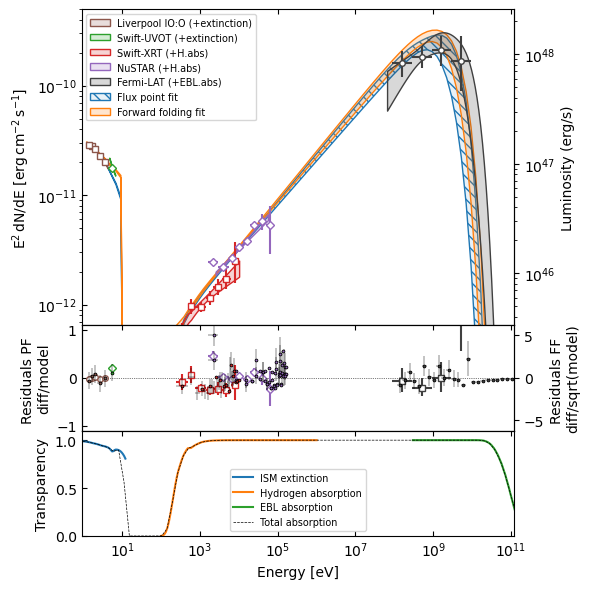

In [33]:
fig, axs = plt.subplots(nrows=3,figsize=(6, 6),dpi=100, height_ratios=[3, 1, 1],sharex=True)
plt.axes(axs[0])

ax = None
ax = plot_model_points(ax,liverpool_datasets,liverpool_only_model['OP313'].spectral_model,liverpool_only_points,'tab:brown','Liverpool IO:O (+extinction)',marker='s')
ax = plot_model_points(ax,uvot_datasets,uvot_only_model['OP313'].spectral_model,uvot_only_points,'tab:green','Swift-UVOT (+extinction)',marker='D')
ax = plot_model_points(ax,xrt_datasets,xrt_only_model['OP313'].spectral_model,xrt_only_points,'tab:red','Swift-XRT (+H.abs)',marker='s',)
ax = plot_model_points(ax,nustar_datasets,nustar_only_model['OP313'].spectral_model,nustar_only_points,'tab:purple','NuSTAR (+H.abs)',marker='D')
ax = plot_model_points(ax,fermi_datasets,fermi_only_model['OP313'].spectral_model,fermi_only_points,'0.25','Fermi-LAT (+EBL.abs)')
draw_sed_contours(model=sky_model_full.spectral_model, ax=ax,
                  energy_edges=ax.get_xlim()*u.eV,color='tab:blue',facealpha=0.1,label='Flux point fit',hatch='\\\\\\',zorder=-2)
draw_sed_contours(model=sky_model_full_ff.spectral_model, ax=ax,
                  energy_edges=ax.get_xlim()*u.eV,color='tab:orange',facealpha=0.2,label='Forward folding fit',zorder=-1)

ax.set_ylim(6.5e-13,5e-10)
ax.set_xlim(0.8,3e10)
ax.legend(fontsize='x-small',loc=2,ncol=1)
ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')

def flx2lum(x):
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
    dL = cosmo.luminosity_distance(0.997).to(u.cm).value
    return x * 4 * np.pi * dL**2
def lum2flux(x):
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
    dL = cosmo.luminosity_distance(0.997).to(u.cm).value
    return x / (4 * np.pi * dL**2)

secay = ax.secondary_yaxis('right', functions=(flx2lum, lum2flux))
secay.set_ylabel('Luminosity (erg/s)')


#### SECOND PANEL (residuals flux point fit)
plt.axes(axs[1])
for d in joint_fluxpoint_datasets:
    x     = d.data.energy_ref[0].to('eV')
    model = d.flux_pred().squeeze()
    y     = (d.residuals().squeeze()/model).to('')
    xerr  = d.data.energy_axis.as_plot_xerr
    xerr  = [xerr[0].to('eV'),xerr[1].to('eV')]
    yerr  = d.data._plot_get_flux_err(sed_type="dnde")
    yerr = [[(yerr[0].data.squeeze()*d.residuals().unit/model).to('')],
            [(yerr[1].data.squeeze()*d.residuals().unit/model).to('')]]
    try:
        if 'Fermi-LAT' in d.name:
            axs[1].errorbar(x=x,xerr=xerr,y=y,yerr=yerr, color='0.25',marker='s',markersize=4,mfc='white')
        elif 'NuSTAR' in d.name:
            axs[1].errorbar(x=x,xerr=xerr,y=y,yerr=yerr, color='tab:purple',marker='D',markersize=4,mfc='white')
        elif 'Swift-XRT' in d.name:
            axs[1].errorbar(x=x,xerr=xerr,y=y,yerr=yerr, color='tab:red',marker='s',markersize=4,mfc='white')
        elif 'Swift-UVOT' in d.name:
            axs[1].errorbar(x=x,xerr=xerr,y=y,yerr=yerr, color='tab:green',marker='D',markersize=4,mfc='white')
        elif 'Liverpool' in d.name:
            axs[1].errorbar(x=x,xerr=xerr,y=y,yerr=yerr, color='tab:brown',marker='o',markersize=4,mfc='white')
    except:
        print('error '+d.name)
        continue

secay = axs[1].twinx()

for d in joint_event_datasets:
    if 'Fermi-LAT' in d.name:
        d.plot_residuals_spectral(ax=secay,mfc='0.25',color='black',markersize=2,markeredgewidth=0.6,
                                  method="diff/sqrt(model)",lw=0.33,zorder=-10)
    elif 'NuSTAR' in d.name:
        d.plot_residuals_spectral(ax=secay,mfc='tab:purple',color='black',markersize=2,markeredgewidth=0.6,
                                  method="diff/sqrt(model)",lw=0.33,errorevery=10, markevery=5,zorder=-10)
    elif 'Swift-XRT' in d.name or 'Swift_XRT' in d.name:
        d.plot_residuals_spectral(ax=secay,mfc='tab:red',color='black',markersize=2,markeredgewidth=0.6,
                                  method="diff/sqrt(model)",lw=0.33,zorder=-10, markevery=3)
    elif 'Swift-UVOT' in d.name or 'Swift_UVOT' in d.name or 'sw' in d.name:
        d.plot_residuals_spectral(ax=secay,mfc='tab:green',color='black',markersize=2,markeredgewidth=0.6,
                                  method="diff/sqrt(model)",lw=0.33,zorder=-10)
    elif 'Liverpool' in d.name:
        d.plot_residuals_spectral(ax=secay,mfc='tab:brown',color='black',markersize=2,markeredgewidth=0.6,
                                  method="diff/sqrt(model)",lw=0.33,zorder=-10)

axs[1].set_ylabel('Residuals PF \ndiff/model')
secay.set_ylabel('Residuals FF \ndiff/sqrt(model)')
axs[1].set_ylim(-1.1,1.1)
secay.set_ylim(-6.2,6.2)
axs[1].axhline(0,ls='dotted',lw=0.5,color='black',zorder=-1000)

#### THIRD PANEL (transparency)

plt.axes(axs[2])

ax2 = axs[2]

ax2.plot(
    np.geomspace(0.01*u.eV,12*u.eV,100).to('eV').value,
    dust_extinc(np.geomspace(0.01*u.eV,12*u.eV,100)),
    label='ISM extinction',
)

ax2.plot(
    np.geomspace(0.1e3*u.eV,1000e3*u.eV,100).to('eV').value,
    hyd_absorpt(np.geomspace(0.1*u.keV,1000*u.keV,100)),
    label='Hydrogen absorption',
)
ax2.plot(
    np.geomspace(0.3e9*u.eV,500e9*u.eV,100).to('eV').value,
    ebl_absorpt(np.geomspace(0.3*u.GeV,500*u.GeV,100)),
    label='EBL absorption',
)

ax2.plot(
    np.geomspace(0.01*u.eV,500e9*u.eV,100).to('eV').value,
    total_abs(np.geomspace(0.01*u.eV,500*u.GeV,100)),
    label='Total absorption',
    color='black', ls='dashed', lw=0.5,
)

ax2.set_ylim(0,1.1)
#ax2.set_yscale('log')
ax2.set_ylabel('Transparency')
ax2.set_xlabel('Energy [eV]')
ax.set_xlabel('')
ax2.legend(fontsize='x-small')
ax2.tick_params(top=True, labeltop=False, bottom=True, labelbottom=True,direction='in')
axs[0].tick_params(top=True, labeltop=False, bottom=False, labelbottom=False,direction='in')
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=False,direction='in')

ax2.set_xlim(0.9,1.2e11)

plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.savefig(f'{basedir}/Figures/{dataset}/JointFit_dataset_events_fluxpoints.pdf',bbox_inches='tight')
fig.savefig(f'{basedir}/Figures/{dataset}/JointFit_dataset_events_fluxpoints.png',bbox_inches='tight',dpi=150)

In [34]:
!readlink -f .

/home/mnievas/Projects/gammapy_mwl_workflow/Notebooks/DatasetAnalysis/MJD60384


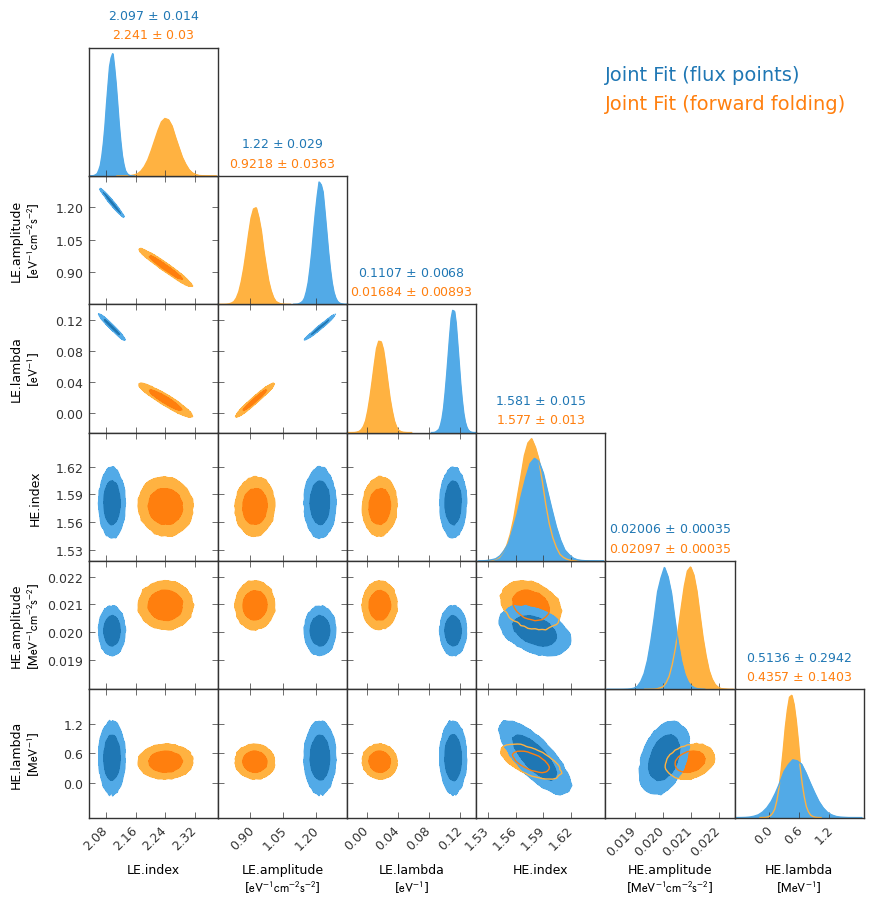

In [39]:
from gammapy.modeling import Parameters
import pygtc
import logging

def get_samples(model,N=100000):
    free_pars = model.covariance.parameters.free_parameters.unique_parameters
    free_pars = [p for k,p in enumerate(free_pars) if free_pars[k].name]
    free_pars = [p for k,p in enumerate(free_pars) if free_pars[k].name]
    
    free_pars = Parameters(free_pars)
    cov = model.covariance.get_subcovariance(free_pars)
    covm = cov.data
    labl = cov.parameters.names
    mean = cov.parameters.value
    return(np.random.multivariate_normal(mean, covm, N),mean,labl)

samples = {
    'Joint Fit (flux points)': get_samples(sky_model_full.spectral_model),
    'Joint Fit (forward folding)': get_samples(sky_model_full_ff.spectral_model)
}

samples_keys = list(samples.keys())
samples_vals = list([samples[n][0] for n in samples_keys])
samples_labl = samples[samples_keys[0]][2]

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

GTC = pygtc.plotGTC(chains=samples_vals,
                    #paramNames=samples_labl,
                    chainLabels=samples_keys,
                    figureSize=10,
                    #plotDensity=(True,True),
                    labelRotation=(True,False),
                    nContourLevels=2,
                    smoothingKernel=0.2,
                    customLegendFont={'family':'Arial', 'size':14},
                    customTickFont={'family':'Arial', 'size':9},
                    colorsOrder=['blues','oranges'],
                    paramNames=['LE.index','LE.amplitude\n[$\mathrm{eV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-2}$]',
                                'LE.lambda\n[$\mathrm{eV}^{-1}$]',
                                'HE.index','HE.amplitude\n[$\mathrm{MeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-2}$]',
                                'HE.lambda\n[$\mathrm{MeV}^{-1}$]'],
                   )

def sci_not(v,err,rnd=3):
    power = - int(('%E' % v)[-3:])+1
    if (power>=-1) and (power<=3):
        rnd=rnd+power-1
        power = 0
    if power>3:
        power = power-2
        rnd += 2
    
    valr = str(round(v*10**power,rnd))
    errr = str(round(err*10**power,rnd))
    if power==0:
        return f'{valr} $\\pm$ {errr}'
    else:
        expo = '$\\times 10^{'+f'{-power:.0f}'+'}$'
        return f'({valr} $\\pm$ {errr}){expo}'
    


values_FF = list(sky_model_full_ff.spectral_model.covariance.parameters.free_parameters.unique_parameters.to_table()['value'])
values_PO = list(sky_model_full.spectral_model.covariance.parameters.free_parameters.unique_parameters.to_table()['value'])
errors_FF = list(sky_model_full_ff.spectral_model.covariance.parameters.free_parameters.unique_parameters.to_table()['error'])
errors_PO = list(sky_model_full.spectral_model.covariance.parameters.free_parameters.unique_parameters.to_table()['error'])

for k,ax in enumerate(GTC.figure.axes[-7:-1]):
    ax.text(0.5, 1.25, sci_not(values_PO[k],errors_PO[k]), 
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes, 
                size='9', color='tab:blue')
    ax.text(0.5, 1.1, sci_not(values_FF[k],errors_FF[k]), 
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes, 
                size='9', color='tab:orange')

GTC.figure.savefig(f'{basedir}/Figures/{dataset}/JointFit_dataset_events_fluxpoints_modelpars_corner.pdf',bbox_inches='tight')

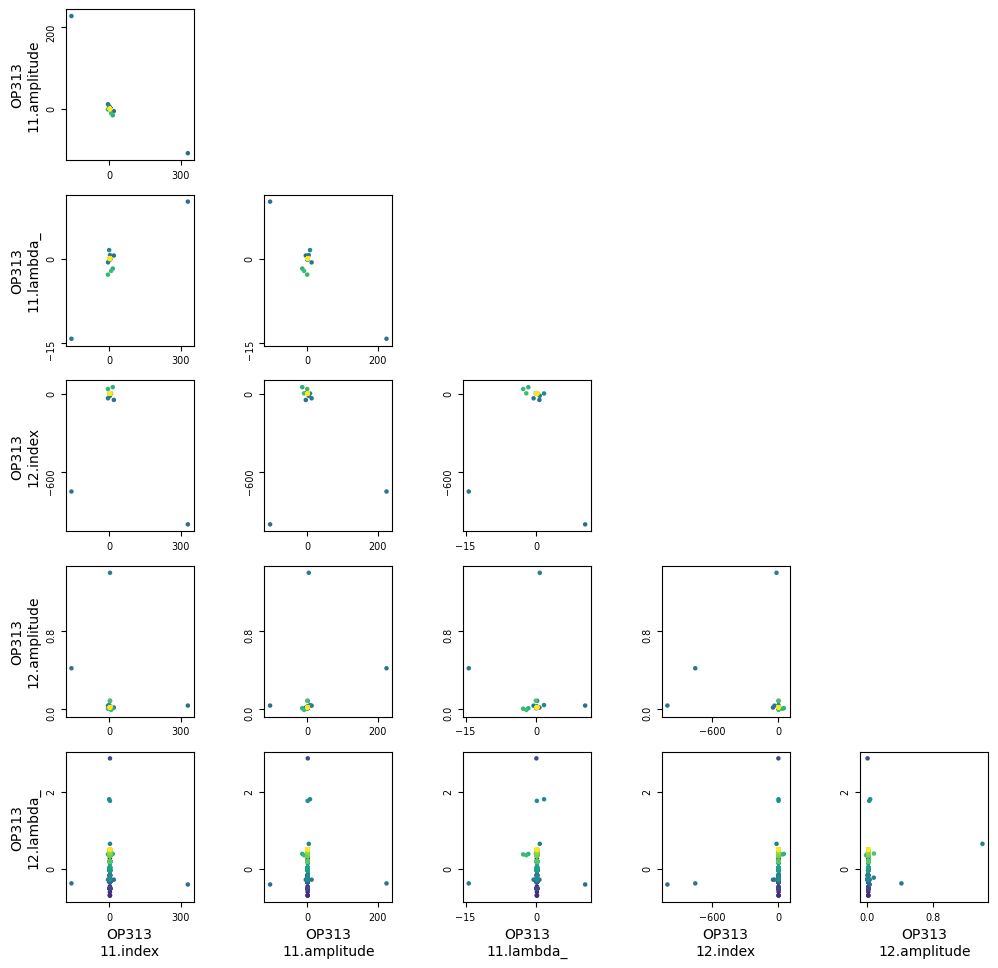

In [36]:
from matplotlib import ticker

len_trace = len(joint_fluxpoint_fit_result_abs.trace.columns)
fig,axs=plt.subplots(nrows=len_trace,ncols=len_trace,figsize=(len_trace*3/2+3,len_trace*3/2+3))

for c1 in range(len_trace):
    axs[c1][0].set_visible(False)
    
    for c2 in range(1,c1):
        t1 = joint_fluxpoint_fit_result_abs.trace.columns[c1]
        t2 = joint_fluxpoint_fit_result_abs.trace.columns[c2]
        axs[c1][c2].scatter(t2,t1,c=np.arange(len(joint_fluxpoint_fit_result_abs.trace)),s=5)
        axs[c1][c2].tick_params(axis='y', labelrotation=90, labelsize='x-small')
        axs[c1][c2].tick_params(axis='x', labelsize='x-small')
        axs[c1][c2].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[c1][c2].yaxis.set_major_locator(plt.MaxNLocator(2))

        if c2 == 1:
            axs[c1][c2].set_ylabel(joint_fluxpoint_fit_result_abs.trace.colnames[c1].replace('.spectral.model','\n').replace('OP313-syst-','').replace('.model',''))

    if c1 == len_trace-1:
        for c2 in range(1,c1):
            axs[c1][c2].set_xlabel(joint_fluxpoint_fit_result_abs.trace.colnames[c2].replace('.spectral.model','\n').replace('OP313-syst-','').replace('.model',''))
    
    for c2 in range(c1,len_trace):
        axs[c1][c2].set_visible(False)


plt.tight_layout()

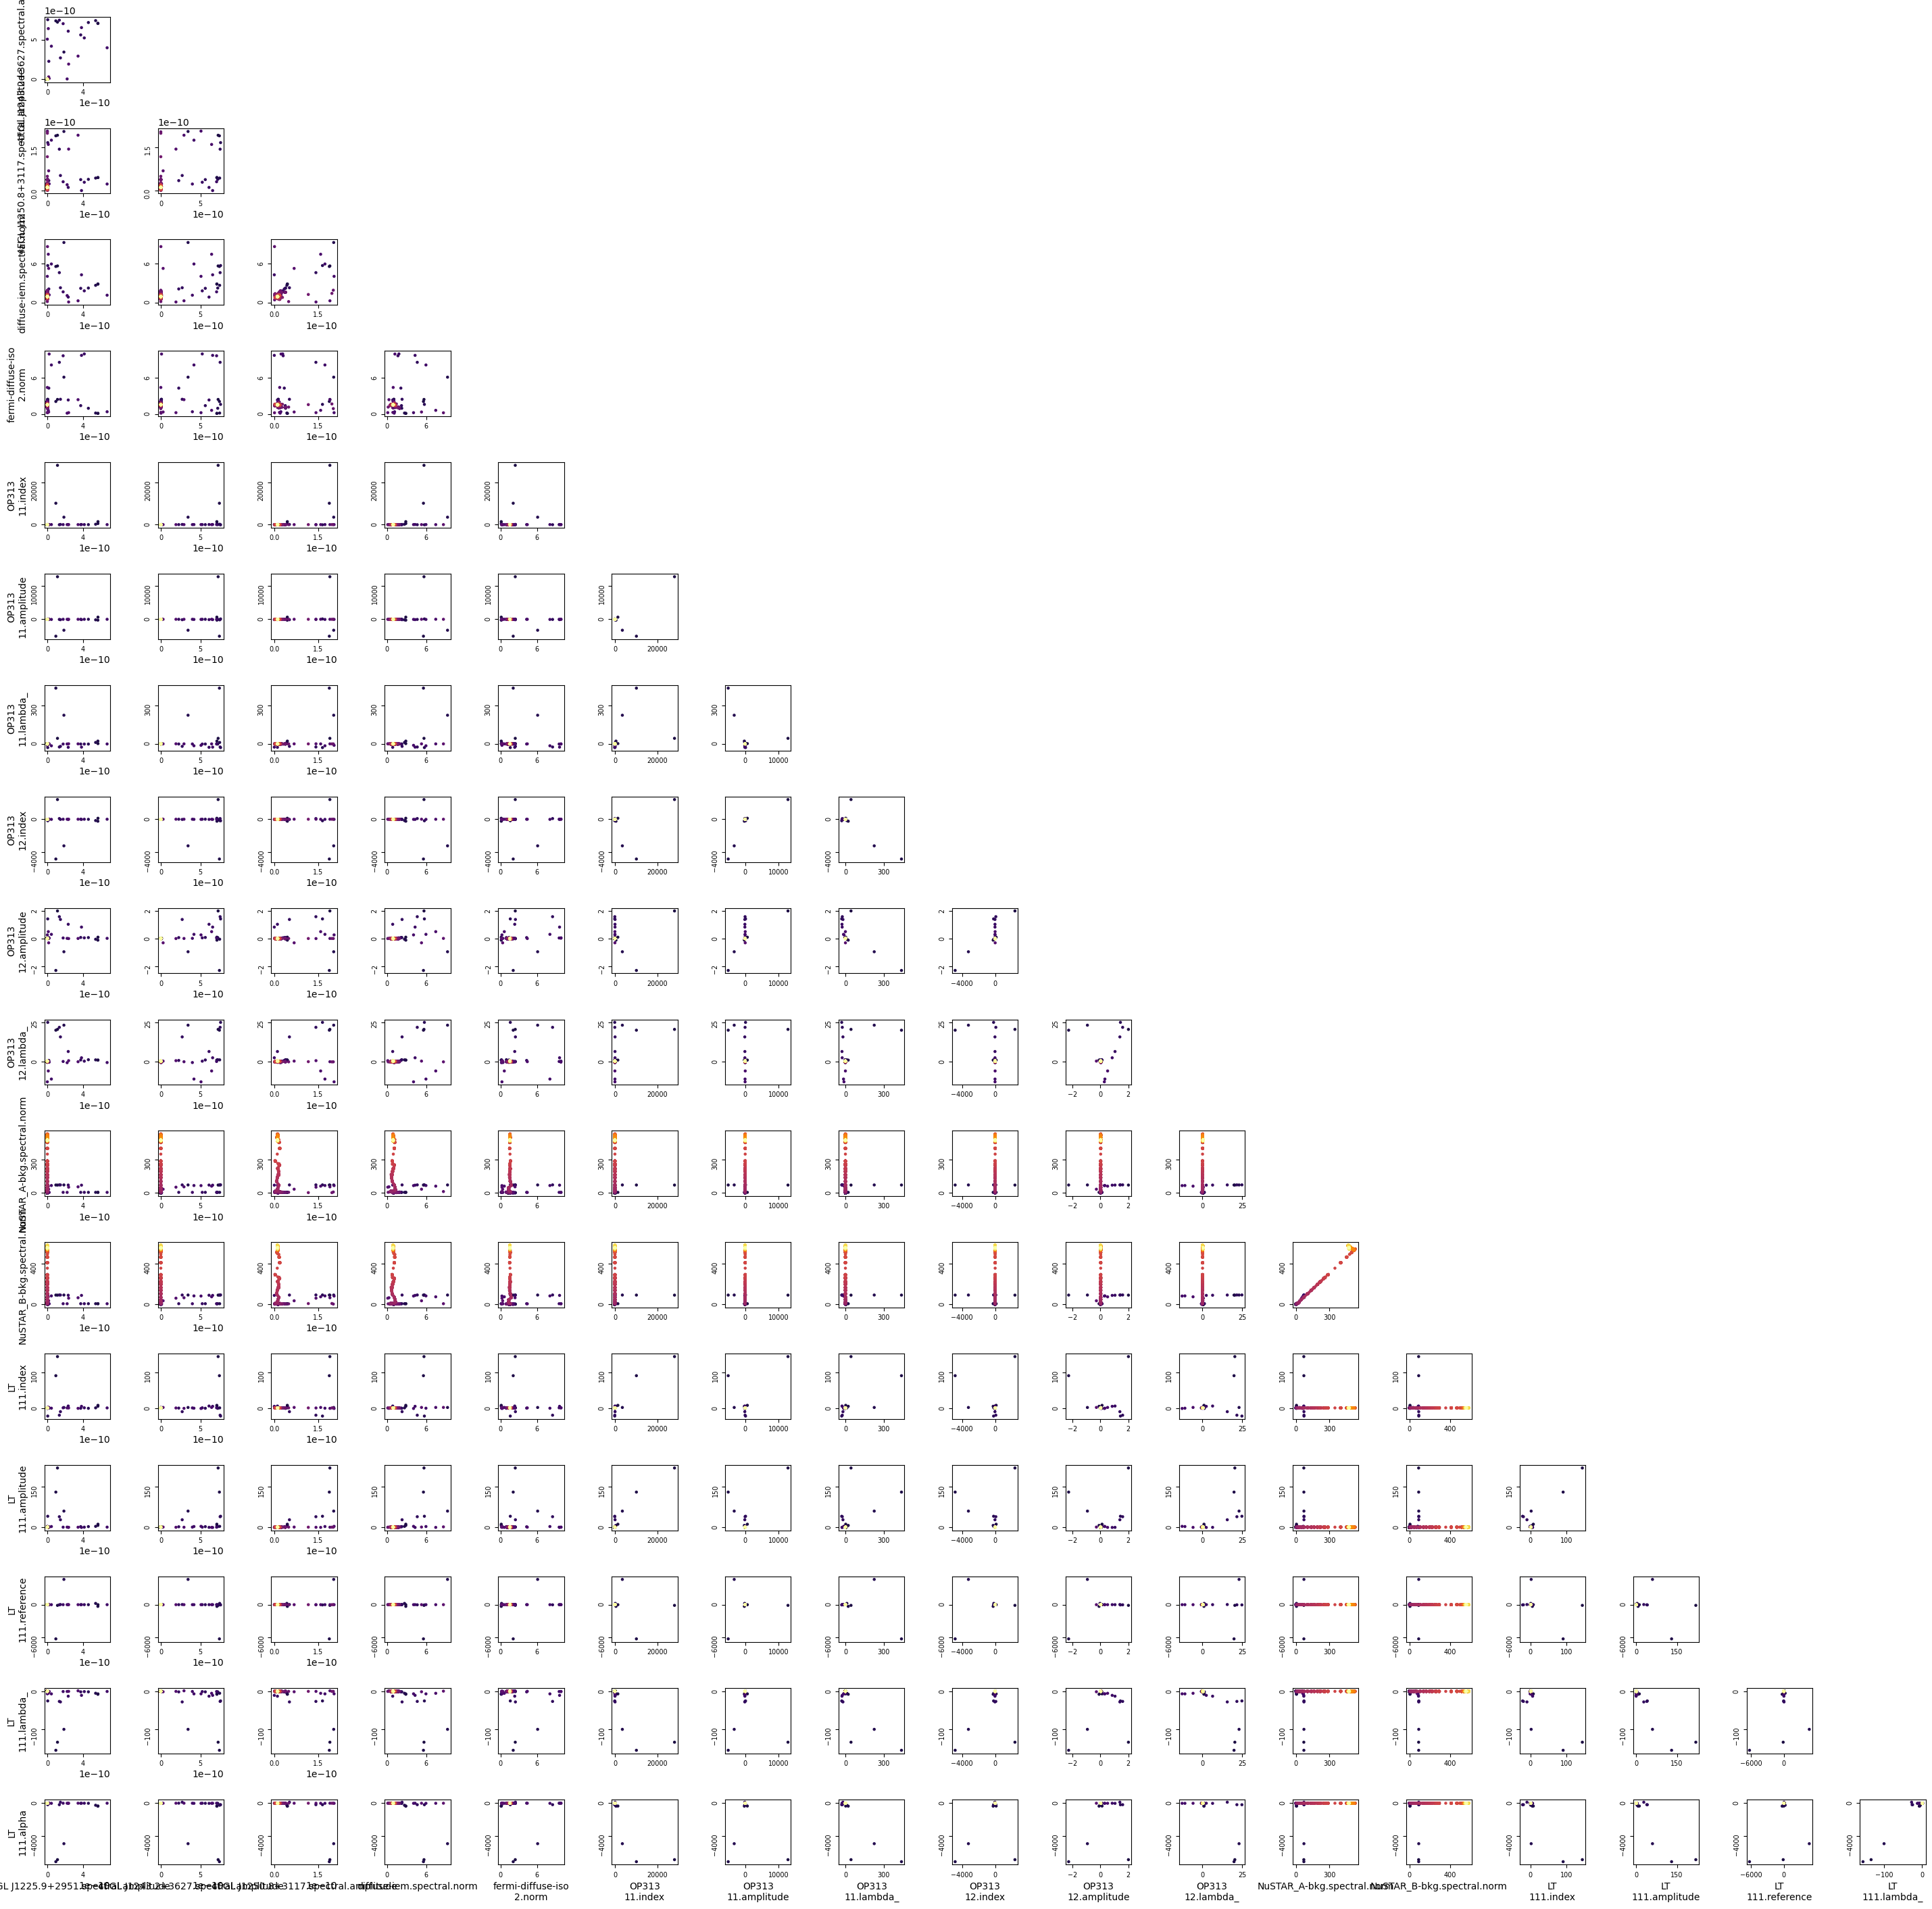

In [37]:
from matplotlib import ticker

len_trace = len(joint_event_fit_result_abs.trace.columns)
fig,axs=plt.subplots(nrows=len_trace,ncols=len_trace,figsize=(len_trace*3/2+3,len_trace*3/2+3))

for c1 in range(len_trace):
    axs[c1][0].set_visible(False)
    
    for c2 in range(1,c1):
        t1 = joint_event_fit_result_abs.trace.columns[c1]
        t2 = joint_event_fit_result_abs.trace.columns[c2]
        axs[c1][c2].scatter(t2,t1,c=np.arange(len(joint_event_fit_result_abs.trace)),s=5,cmap='inferno')
        
        axs[c1][c2].tick_params(axis='y', labelrotation=90, labelsize='x-small')
        axs[c1][c2].tick_params(axis='x', labelsize='x-small')
        axs[c1][c2].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[c1][c2].yaxis.set_major_locator(plt.MaxNLocator(2))

        if c2 == 1:
            axs[c1][c2].set_ylabel(joint_event_fit_result_abs.trace.colnames[c1].replace('.spectral.model','\n').replace('OP313-syst-','').replace('.model',''))

    if c1 == len_trace-1:
        for c2 in range(1,c1):
            axs[c1][c2].set_xlabel(joint_event_fit_result_abs.trace.colnames[c2].replace('.spectral.model','\n').replace('OP313-syst-','').replace('.model',''))
    
    for c2 in range(c1,len_trace):
        axs[c1][c2].set_visible(False)


plt.tight_layout()

## GTIs

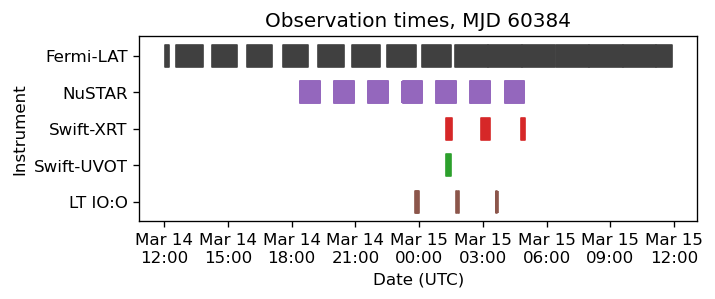

In [38]:
import matplotlib

fig,ax = plt.subplots(figsize=(6,2),dpi=120)

dataset_dict = {len(joint_event_datasets)-k-1: d.name for k,d in enumerate(joint_event_datasets)}

for k in dataset_dict:
    d = joint_event_datasets[dataset_dict[k]]
    if 'Fermi' in d.name:
        color='0.25'
        yvalu=5 
    elif 'NuSTAR' in d.name:
        color='tab:purple'
        yvalu=4
    elif 'XRT' in d.name:
        color='tab:red'
        yvalu=3
    elif 'sw' in d.name:
        color='tab:green'
        yvalu=2
    elif 'Liverpool' in d.name:
        color='tab:brown'
        yvalu=1
    
    for row in d.gti.table:
        ax.fill_betweenx(
            y=[yvalu-0.3,yvalu+0.3],
            x1=row['START'].datetime,
            x2=row['STOP'].datetime,
            color=color,
        )

def plot2mjd(t):
    from astropy.time import Time
    '''Convert from matplotlib plot date to mjd'''
    return Time(t, format="plot_date").mjd


def mjd2plot(mjd):
    from astropy.time import Time
    '''Convert from mjd to matplotlib plot'''
    return Time(mjd, format="mjd").plot_date


ax.set_yticks([5,4,3,2,1])
ax.set_yticklabels(['Fermi-LAT','NuSTAR','Swift-XRT','Swift-UVOT','LT IO:O'])
ax.set_title(f'Observation times, MJD {int(row["START"].mjd+0.5)}')
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %e\n%H:%M'))
ax.set_xlabel('Date (UTC)')
ax.set_ylabel('Instrument')
fig.savefig(f'{basedir}/Figures/MJD60384/Dataset_GTIs.pdf',bbox_inches='tight')